This script performs data exploration and feature engineering. The data used is LC 2014 loan data processed by extracting common columns shared with current data from API and reformatting column names (e.g., underscores removed). See DataPreparation.ipynb for processing detials.

In [1]:
import numpy as np
import pandas as pd
from time import strptime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing

### data cleaning and preparation

In [367]:
# load data
df = pd.read_csv('../data/data2014.csv')
print 'size of full data: ', df.shape
df.loanstatus.value_counts(normalize=True)

size of full data:  (235631, 110)


Fully Paid            0.732877
Charged Off           0.166448
Current               0.094729
Late (31-120 days)    0.003158
In Grace Period       0.002147
Late (16-30 days)     0.000637
Default               0.000004
Name: loanstatus, dtype: float64

In [368]:
# subset data of interest: fully paid or charged off
df = df.query('loanstatus=="Fully Paid" or loanstatus=="Charged Off"')
print 'size of data used: ', df.shape
df['loanstatus'] = df.loanstatus.map({'Fully Paid':0, 'Charged Off':1})
df.loanstatus.value_counts(normalize=True)

size of data used:  (211907, 110)


0    0.814919
1    0.185081
Name: loanstatus, dtype: float64

In [369]:
# classify features: allNaN, numeric, object
fnames_allNaN, fnames_numeric, fnames_obj = [],[],[]
for col in df.columns.values:
    if df[col].isnull().mean()==1:
        fnames_allNaN.append(col)
    else:
        ctype = df[col].dtype
        if ctype == 'object':
            fnames_obj.append(col)
        else:
            fnames_numeric.append(col)

print('numbers of numeric, object, allNaN features are %d, %d, %d' % (len(fnames_numeric),len(fnames_obj),len(fnames_allNaN)))

numbers of numeric, object, allNaN features are 59, 20, 31


In [370]:
# remove features with constant value
for col in fnames_numeric + fnames_obj:
    val = df[col][~df[col].isnull().values] # exclude null
    val = val.unique()
    if len(val)==1:
        if col in fnames_numeric:
            print( 'feature %s has only one value %f' % (col,val[0]) )
            fnames_numeric.remove(col)
        else:
            print( ('feature %s has only one value: '+val[0]) % col )
            fnames_obj.remove(col)

feature disbursementmethod has only one value: Cash
feature applicationtype has only one value: Individual


In [371]:
# remove id & loanstatus & issued: not used for fitting
fnames_obj.remove('id')
fnames_numeric.remove('loanstatus')
fnames_obj.remove('issued')

# loanamnt == fundedamnt: remove fundedamnt
fnames_numeric.remove('fundedamnt')

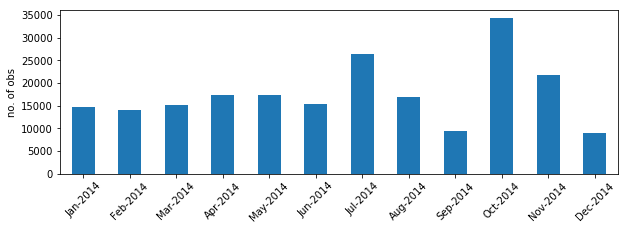

In [372]:
# number of observations in each month
sub_cnt_issued=df.groupby(['issued']).loanstatus.count().reindex(df.issued.unique()[::-1]).reset_index()
fig = plt.figure(figsize=(10,3))
sub_cnt_issued.ix[:,1].plot(kind='bar')
plt.ylabel('no. of obs')
plt.xticks(range(12), sub_cnt_issued.ix[:,0].values, rotation=45);

In [373]:
# split train-test sets
# train: Jan-Sep, test: Oct-Dec
issued_dic = dict( zip(sub_cnt_issued.ix[:,0].values,\
    ([1 for i in range(9)]+[0 for i in range(3)]) ) )
df['fitting_flag'] = df.issued.map(issued_dic)
df.fitting_flag.value_counts(normalize=True)

1    0.693682
0    0.306318
Name: fitting_flag, dtype: float64

### data exploration and feature engineering

In [374]:
# define some helper functions

def compareDistTrainTest(col, nb):
    # continuous value
    # compare distribution of a feature btw train and test sets
    plt.figure(figsize=(5,4))
    df.query('fitting_flag==1')[col].hist(bins=nb, normed=True, alpha=0.5, color='red', label='train')
    df.query('fitting_flag==0')[col].hist(bins=nb, normed=True, alpha=0.5, color='blue', label='test')
    plt.legend(loc='lower right')
    plt.title('distribution of '+col)
    
def valBucketDistTarget(col, nb, nbkt):
    # continuous value
    # compare avg default rate for each value bucket
    # compare distribution btw default and fully-paid classes
    train = df.query('fitting_flag==1')
    factor = pd.qcut(train[col], nbkt, labels=False)
    tab = df.groupby([factor]).loanstatus.mean().reset_index()
    grpPct = tab.ix[:,1]
    # plot 1
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    grpPct.plot(kind='bar')
    plt.xlabel(col + ' value bucket',fontsize=10)
    plt.ylabel('default rate (training)',fontsize=10)
    rightp=[int(100/nbkt)*x for x in range(1,nbkt)]+[100]
    leftp= [0]+[1+int(100/nbkt)*x for x in range(1,nbkt)]
    plt.xticks(range(nbkt),[str(x[0])+'-'+str(x[1])+'%' for x in zip(leftp,rightp)],\
               fontsize=10,rotation=0)
    # plot 2
    plt.subplot(1,2,2)
    train.query('loanstatus==0')[col].hist(bins=nb, normed=True, alpha=0.5, color='blue', label='FullyPaid')
    train.query('loanstatus==1')[col].hist(bins=nb, normed=True, alpha=0.5, color='red', label='Default')
    plt.legend(loc='lower right')
    plt.title(col + ' distribution in training set')
    
def valAvgDefaultRate(col, fsize):
    # categorical value
    # average default rate for each category of feature value
    train=df.query('fitting_flag==1')
    tab = train.groupby(col).loanstatus.mean().reset_index().\
        rename(columns={'loanstatus':'defaultRate'}).sort_values(by=['defaultRate'])[col].values
    plt.figure(figsize = fsize)
    fig = sns.barplot(x=col, y='loanstatus', data=train, order=tab )
    fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
    plt.xlabel('')
    plt.ylabel('avg default rate')
    plt.title(col+' in training set')
    
def compareDistTrainTestCat(col, fsize):
    # categorical value
    # compare pct of observations in each category btw training and test sets
    tab_train=pd.DataFrame( df.query('fitting_flag==1')[col].value_counts(normalize=True)).\
        reset_index().rename(columns={'emplength':'pct in train'})
    tab_test=pd.DataFrame( df.query('fitting_flag==0')[col].value_counts(normalize=True)).\
        reset_index().rename(columns={'emplength':'pct in test'})
    tab = pd.merge(tab_train, tab_test, on='index', how='outer')
    # plot
    plt.figure(figsize = fsize)
    tab.ix[:,1].plot(kind='bar',color='red',alpha=0.5,label='train')
    tab.ix[:,2].plot(kind='bar',color='blue',alpha=0.5,label='test')
    plt.xlabel(col,fontsize=10)
    plt.ylabel('pct of obs',fontsize=10)
    plt.xticks(range(tab.shape[0]),tab['index'],fontsize=10,rotation=90);
    plt.legend(loc='upper right')

* earliestcrline: The month the borrower's earliest reported credit line was opened

In [375]:
mon = df.earliestcrline.map(lambda x: strptime(x.split('-')[0],'%b').tm_mon).values
yr = df.earliestcrline.map(lambda x: int(x.split('-')[1])).values
# months from earliestcrline to 2014.01
df['earliestcrline_num'] = 12*(2014-yr)-mon

# update feature names
fnames_obj.remove('earliestcrline')
fnames_numeric.append('earliestcrline_num')

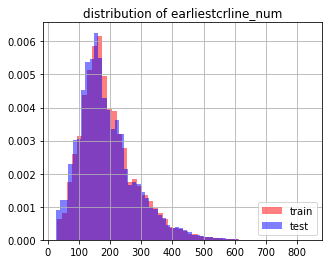

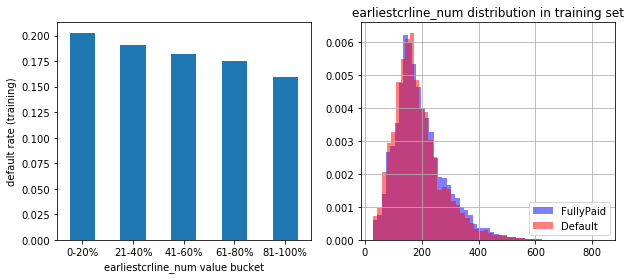

In [378]:
compareDistTrainTest('earliestcrline_num',50)
valBucketDistTarget('earliestcrline_num',50, 5)

* desc: Loan description provided by the borrower

In [379]:
print('pct of NaN desc: %f' % df.desc.isnull().mean() )
# drop this feature
fnames_obj.remove('desc')

pct of NaN desc: 0.932730


* emplength: Employment length in years. 

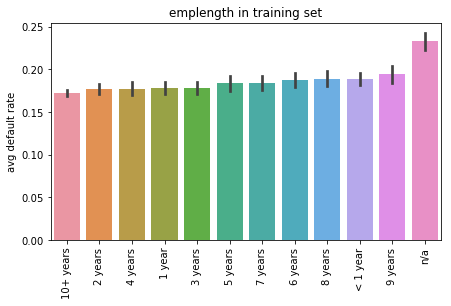

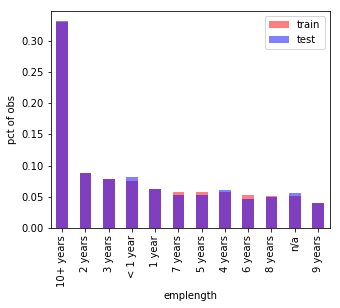

In [380]:
valAvgDefaultRate('emplength', (7,4))
compareDistTrainTestCat('emplength', (5,4))
# treat n/a as 0-year employment

In [381]:
print df.emplength.unique()
df['emplength'].replace('n/a', 0, inplace=True)
df['emplength'].replace('< 1 year', 0.5, inplace=True)
df['emplength'].replace('[^0-9]+', '', inplace=True, regex=True)
df['emplength'] = df['emplength'].astype(float)
print df.emplength.unique()

# update feature names
fnames_obj.remove('emplength')
fnames_numeric.append('emplength')

['10+ years' '8 years' '6 years' '< 1 year' '2 years' '9 years' '7 years'
 '5 years' '3 years' '4 years' 'n/a' '1 year']
[ 10.    8.    6.    0.5   2.    9.    7.    5.    3.    4.    0.    1. ]


* revolutil: Revolving line utilization rate
* intrate: Interest Rate on the loan

In [382]:
# convert to numeric
df.revolutil = df.revolutil.apply(lambda x: str(x).replace('%','')).astype(float)
print df.revolutil.values
df.intrate = df.intrate.apply(lambda x: str(x).replace('%','')).astype(float)
print df.intrate.values

# update feature names
fnames_obj.remove('revolutil')
fnames_obj.remove('intrate')
fnames_numeric.append('revolutil')
fnames_numeric.append('intrate')

[ 29.   31.6  76.2 ...,  46.3  21.5  70.8]
[ 12.39   6.99  15.59 ...,  19.97   7.9   19.2 ]


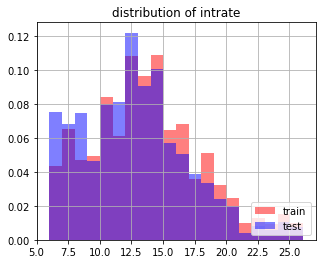

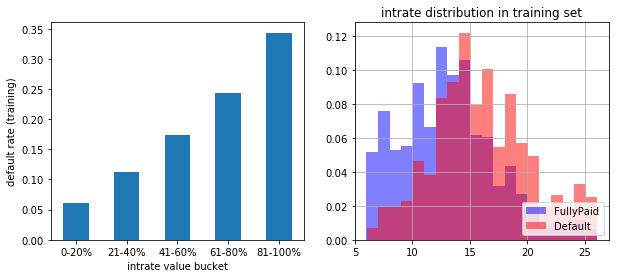

In [383]:
compareDistTrainTest('intrate',20)
valBucketDistTarget('intrate',20, 5)

* grade and subgrade

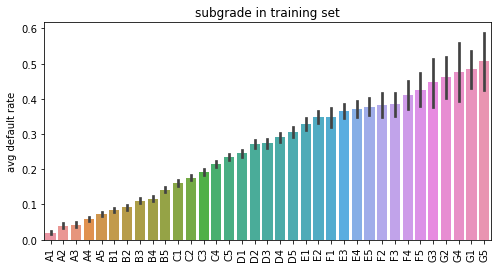

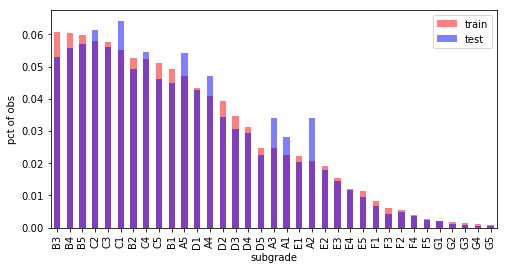

In [384]:
valAvgDefaultRate('subgrade',(8,4))
compareDistTrainTestCat('subgrade',(8,4))

In [385]:
# encode by ordinal numbers
print df.grade.values
print df.subgrade.values
grade_dict = dict(zip(sorted(df.grade.unique()),range(7)))
df.grade.replace(grade_dict, inplace=True)
df.subgrade = df.subgrade.apply(lambda x: grade_dict[x[0]]*5+int(x[1]))
print df.grade.values
print df.subgrade.values

# update feature names
fnames_obj.remove('grade')
fnames_obj.remove('subgrade')
fnames_numeric.append('grade')
fnames_numeric.append('subgrade')

['C' 'A' 'D' ..., 'D' 'A' 'D']
['C1' 'A3' 'D1' ..., 'D5' 'A4' 'D3']
[2 0 3 ..., 3 0 3]
[11  3 16 ..., 20  4 18]


* zipcode

In [387]:
# first 3 digits represent county,state level

# 1. frequency for each zipcode 
df = pd.merge(df, df.query('fitting_flag==1').groupby(['zipcode']).id.count().\
    reset_index().rename(columns={'id':'zipcode_freq'}), how='left', on='zipcode')
# new zipcode in test set has freq 1
df.fillna(value = {'zipcode_freq':1}, inplace=True)
print ('number of NaN zipcode_freq: %d' % df.zipcode_freq.isnull().sum())

# 2. avg default rate for each zipcode
df = pd.merge(df, df.query('fitting_flag==1').groupby(['zipcode'])['loanstatus'].\
    agg([np.mean]).reset_index().rename(columns={'mean':'zipcode_mean_dr'}), how='left', on='zipcode')
# zipcode with freq<=5 has avg default rate across all training data
avgDRtrain = np.mean( df.query('fitting_flag==1').loanstatus )
df.loc[df.zipcode_freq.values<=5, 'zipcode_mean_dr']=avgDRtrain
#df.fillna(value = {'zipcode_mean_dr':avgDRtrain}, inplace=True)
print ('number of NaN zipcode_mean_dr: %d' % df.zipcode_mean_dr.isnull().sum())

# update feature names
fnames_numeric.append('zipcode_freq')
fnames_numeric.append('zipcode_mean_dr')

number of NaN zipcode_freq: 0
number of NaN zipcode_mean_dr: 0


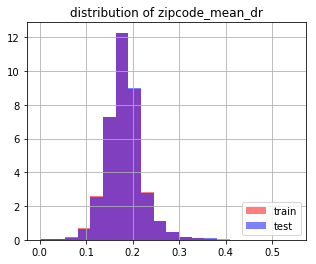

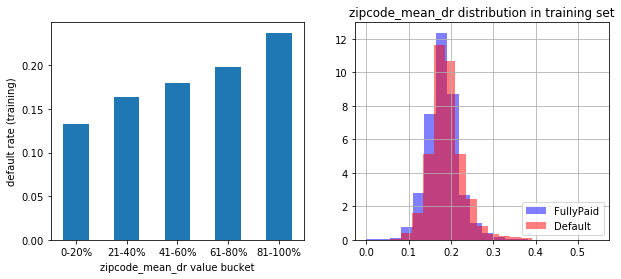

In [389]:
compareDistTrainTest('zipcode_mean_dr',20)
valBucketDistTarget('zipcode_mean_dr',20, 5)

* addrstate

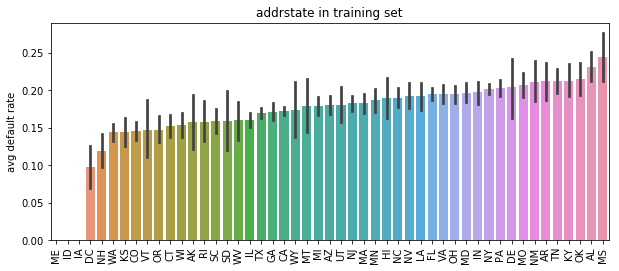

In [390]:
valAvgDefaultRate('addrstate', (10,4))

In [391]:
# 1. frequency for each addrstate
df = pd.merge(df, df.query('fitting_flag==1').groupby(['addrstate']).id.count().\
    reset_index().rename(columns={'id':'addrstate_freq'}), how='left', on='addrstate')
# new addrstate in test set has freq 1
df.fillna(value = {'addrstate_freq':1}, inplace=True)
print ('number of NaN addrstate_freq: %d' % df.addrstate_freq.isnull().sum())

# 2. avg default rate for each addrstate
df = pd.merge(df, df.query('fitting_flag==1').groupby(['addrstate'])['loanstatus'].\
    agg([np.mean]).reset_index().rename(columns={'mean':'addrstate_mean_dr'}), how='left', on='addrstate')
# addrstate with freq<=5 has avg default rate across all training data
avgDRtrain = np.mean( df.query('fitting_flag==1').loanstatus )
df.loc[df.addrstate_freq.values<=5, 'addrstate_mean_dr']=avgDRtrain
#df.fillna(value = {'addrstate_mean_dr':avgDRtrain}, inplace=True)
print ('number of NaN addrstate_mean_dr: %d' % df.addrstate_mean_dr.isnull().sum())

# update feature names
fnames_numeric.append('addrstate_freq')
fnames_numeric.append('addrstate_mean_dr')

number of NaN addrstate_freq: 0
number of NaN addrstate_mean_dr: 0


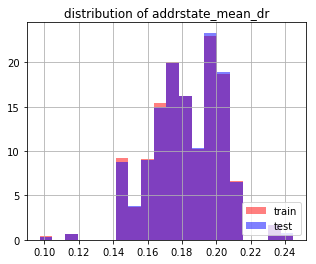

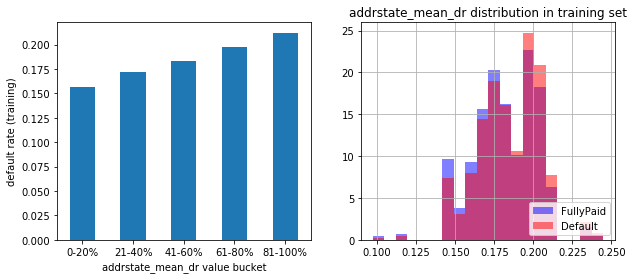

In [392]:
compareDistTrainTest('addrstate_mean_dr',20)
valBucketDistTarget('addrstate_mean_dr',20,5)

* emptitle

In [393]:
df.emptitle = df.emptitle.apply(lambda x: str(x).lower())

# 1. frequency for each emptitle
df = pd.merge(df, df.query('fitting_flag==1').groupby(['emptitle']).id.count().\
    reset_index().rename(columns={'id':'emptitle_freq'}), how='left', on='emptitle')
# new emptitle in test set has freq 1
df.fillna(value = {'emptitle_freq':1}, inplace=True)
print ('number of NaN emptitle_freq: %d' % df.emptitle_freq.isnull().sum())

# 2. avg default rate for each emptitle
df = pd.merge(df, df.query('fitting_flag==1').groupby(['emptitle'])['loanstatus'].\
    agg([np.mean]).reset_index().rename(columns={'mean':'emptitle_mean_dr'}), how='left', on='emptitle')
# emptitle with freq <=5 has avg default rate across all training data
avgDRtrain = np.mean( df.query('fitting_flag==1').loanstatus )
df.loc[df.emptitle_freq.values<=5, 'emptitle_mean_dr']=avgDRtrain
#df.fillna(value = {'emptitle_mean_dr':avgDRtrain}, inplace=True)
print ('number of NaN emptitle_mean_dr: %d' % df.emptitle_mean_dr.isnull().sum())

# update feature names
fnames_numeric.append('emptitle_freq')
fnames_numeric.append('emptitle_mean_dr')

number of NaN emptitle_freq: 0
number of NaN emptitle_mean_dr: 0


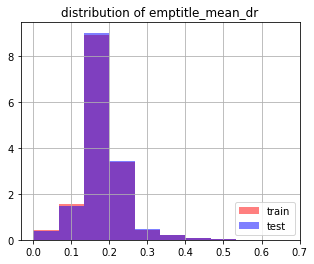

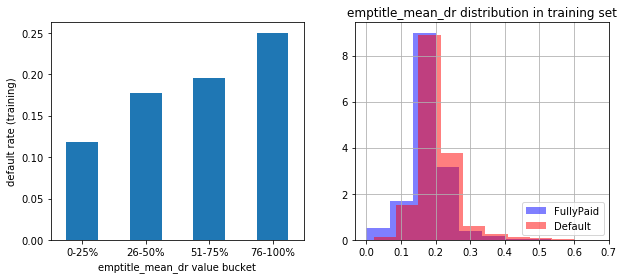

In [398]:
compareDistTrainTest('emptitle_mean_dr',10)
valBucketDistTarget('emptitle_mean_dr',10,4)

* lastcreditpulld: The most recent month LC pulled credit for this loan

In [400]:
dts = pd.to_datetime(df['lastcreditpulld'])
mon = dts.dt.month
yr = dts.dt.year
# 1. months from lastcreditpulld to 2014.01
df['lastcreditpulld_num'] = 12*(yr-2014)+mon
# 2. months from lastcreditpulld to issueDate
iss_mon = df.issued.map(lambda x: strptime(x.split('-')[0],'%b').tm_mon).values
df['lastcreditpulld_iss_diff'] = 12*(yr-2014)+mon-iss_mon

# update feature names
fnames_numeric.append('lastcreditpulld_num')
fnames_numeric.append('lastcreditpulld_iss_diff')
fnames_obj.remove('lastcreditpulld')

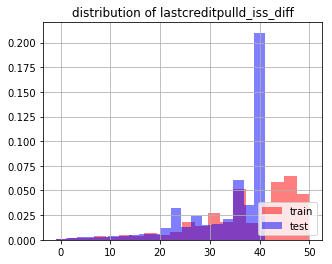

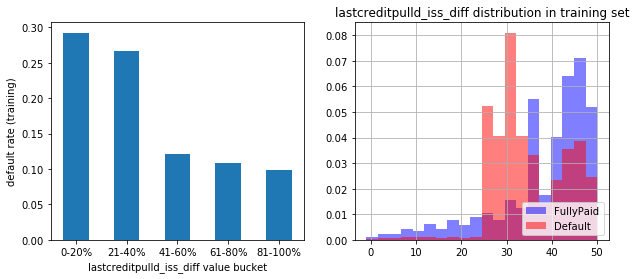

In [409]:
compareDistTrainTest('lastcreditpulld_iss_diff', 20)
valBucketDistTarget('lastcreditpulld_iss_diff', 20, 5)

* purpose

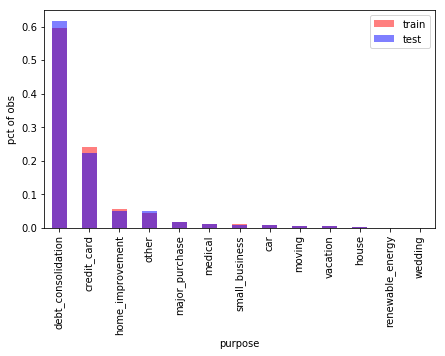

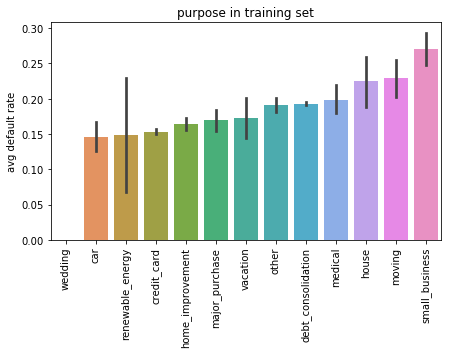

In [415]:
compareDistTrainTestCat('purpose', (7,4))
valAvgDefaultRate('purpose',(7,4))

* installment: The monthly payment owed by the borrower if the loan originates.

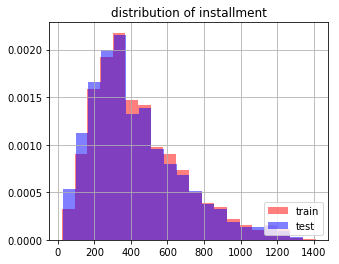

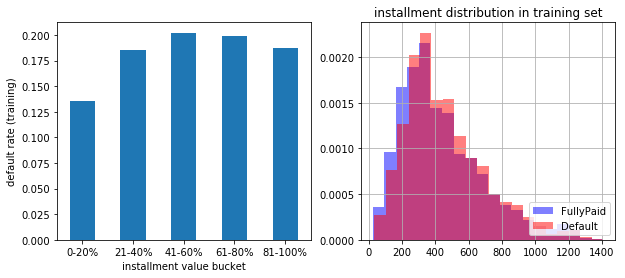

In [426]:
compareDistTrainTest('installment',20)
valBucketDistTarget('installment',20,5)

* bcutil: Ratio of total current balance to high credit/credit limit for all bankcard accounts

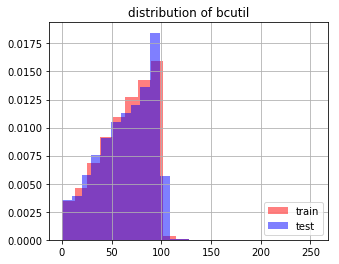

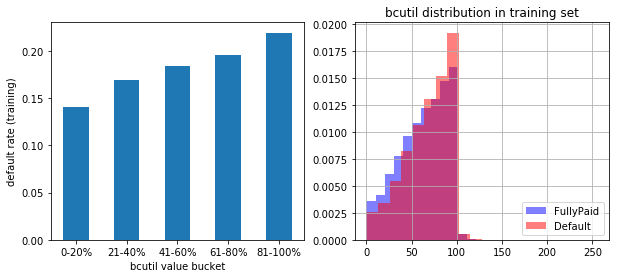

In [428]:
compareDistTrainTest('bcutil',20)
valBucketDistTarget('bcutil',20,5)

* mosinoldilacct: Months since oldest bank installment account opened

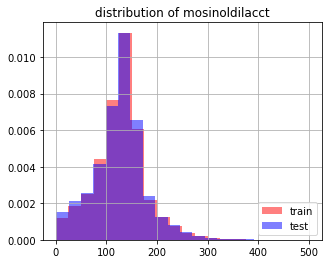

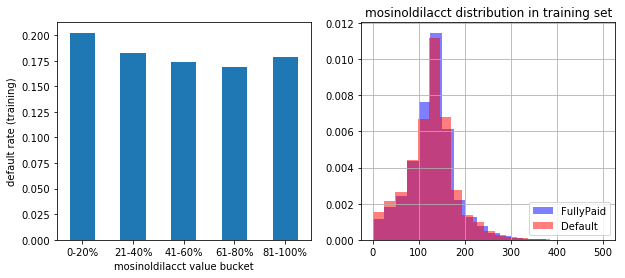

In [430]:
compareDistTrainTest('mosinoldilacct',20)
valBucketDistTarget('mosinoldilacct',20,5)

#### label encoding

In [451]:
le = preprocessing.LabelEncoder()
fnames_le = []
dict_le = dict()

for col in fnames_obj:
    col_le = col+'LE'
    df[col_le] = le.fit_transform(df[col].astype(str))
    fnames_le.append(col_le)
    dict_le[col_le] = le.classes_
print fnames_le

['termLE', 'addrstateLE', 'initialliststatusLE', 'homeownershipLE', 'emptitleLE', 'purposeLE', 'verificationstatusLE', 'zipcodeLE']


### save processed features

In [469]:
print 'size of processed full data: ',df.shape
df.to_csv('../data/train_test2014.csv', index=False)

import pickle
with open('../data/fnames.pickle','wb') as f:
    pickle.dump([fnames_numeric,fnames_le,fnames_obj],f)

size of processed full data:  (211907, 128)
